In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from random import sample

# you can choose one of the following package for image reading/processing
#import cv2
import PIL

In [2]:
#自訂義function以利gradient計算
def read_data(cwd):
    X = []
    for i in os.listdir(cwd):
        temp = cwd + '\\' + i
        for obj in os.listdir(temp):
            Temp = temp + "\\" + obj
            #print(Temp)
            image = PIL.Image.open(Temp)
            X.append(np.array(image))
    return np.array(X)

def softmax(w, X):
    return np.exp(X @ w) / np.sum(np.exp(X @ w),axis=1).reshape(-1,1)

def cross_entropy(t, y_hat):
    return (-1) * np.sum(t * np.log(y_hat))/len(t)

def acc(Y, Y_hat):
    count = 0
    for i in range(len(Y)):
        if np.where(Y[i] == 1)[0] == np.argmax(Y_hat[i]):
            count += 1
    return count / len(Y)

def ls(x,y):
    A = x
    AT = A.T
    ATA = AT @ A
    ATA_inv_ATb = np.linalg.pinv(ATA) @ AT @ y
    return ATA_inv_ATb

In [3]:
data = read_data(os.getcwd() + "\\EMNIST")

X = data/255

#1-of-K binary coding
Y = np.zeros((1024,8))
for j in range(8):
    for i in range(128):
        Y[i+j*128,j] = 1
X = X.reshape(1024,784)

tst_i = np.random.choice(range(128),32, replace = False)
tst_i = np.array([np.array(tst_i)+128*i for i in range(8)]).flatten()
trn_i = list(set(i for i in range(1024))-set(tst_i))

X_train = X[trn_i]
Y_train = Y[trn_i]
X_test = X[tst_i]
Y_test = Y[tst_i]

# Q1.1

In [4]:
lsc_w = ls(X_train,Y_train)

In [5]:
lsc_train_loss = np.mean(np.sqrt(np.mean(((X_train@lsc_w)-Y_train)**2, axis = 1)))
lsc_test_loss = np.mean(np.sqrt(np.mean(((X_test@lsc_w)-Y_test)**2, axis = 1)))
lsc_train_acc = acc(Y_train, X_train@lsc_w)
lsc_test_acc = acc(Y_test, X_test@lsc_w)

In [6]:
pd.DataFrame({"Loss":[lsc_train_loss, lsc_test_loss],
              "Accuracy":[lsc_train_acc, lsc_test_acc]},
             index = [["Least Square for Classification", "Least Square for Classification"],
                      ["Training","Testing"]]
            ).round(4)

Loss  Accuracy
Least Square for Classification Training  0.0755    1.0000
                                Testing   1.3583    0.3047

# Q1.2

In [7]:
rate = 0.1
epoch = 500

In [8]:
#BGD
w = np.zeros((784,8))
new_w = np.zeros((784,8))
iter_count = 0
BGD_train_loss = []
BGD_test_loss = []
BGD_train_acc = []
BGD_test_acc = []

while (iter_count < epoch):
    # gradient descent
    partial_derivative = X_train.T @ ((Y_train-softmax(w,X_train))/len(Y_train))
    new_w = w + rate * partial_derivative
    if np.sum(np.abs(new_w - w)) < 0.01:
        break
    w = new_w
    l_trn = cross_entropy(Y_train, softmax(w, X_train))
    l_tst = cross_entropy(Y_test, softmax(w, X_test))
    BGD_train_loss.append(l_trn)
    BGD_test_loss.append(l_tst)
    BGD_train_acc.append(acc(Y_train, X_train@w))
    BGD_test_acc.append(acc(Y_test, X_test@w))
    #print("iter_count: ", iter_count, ";train loss:", l_trn, ";test loss", l_tst)
    iter_count += 1
    
BGD_w = w

In [9]:
#SGD
w = np.zeros((784,8))
new_w = np.zeros((784,8))
iter_count = 0
SGD_train_loss = []
SGD_test_loss = []
SGD_train_acc = []
SGD_test_acc = []

n_batch = len(X_train)
batch_size = len(X_train)//n_batch

while (iter_count < epoch):
    ind = np.array([i for i in range(len(X_train))])
    np.random.shuffle(ind)
    ind = ind.reshape(n_batch,-1)
    for i in range(n_batch):
        partial_derivative += X_train[ind[i]].T @ ((Y_train[ind[i]]-softmax(w,X_train[ind[i]]))/len(Y_train[ind[i]]))
    partial_derivative /= n_batch
    new_w = w + rate * partial_derivative
    if np.sum(np.abs(new_w - w)) < 0.01:
        break
    w = new_w
    l_trn = cross_entropy(Y_train, softmax(w, X_train))
    l_tst = cross_entropy(Y_test, softmax(w, X_test))
    SGD_train_loss.append(l_trn)
    SGD_test_loss.append(l_tst)
    SGD_train_acc.append(acc(Y_train, X_train@w))
    SGD_test_acc.append(acc(Y_test, X_test@w))
    #print("iter_count: ", iter_count, ";train loss:", l_trn, ";test loss", l_tst)
    iter_count += 1
    
SGD_w = w

In [10]:
#mini-batch SGD
w = np.zeros((784,8))
new_w = np.zeros((784,8))
iter_count = 0
mini_train_loss = []
mini_test_loss = []
mini_train_acc = []
mini_test_acc = []

n_batch = 4
batch_size = len(X_train)//n_batch

while (iter_count < epoch):
    ind = np.array([i for i in range(len(X_train))])
    np.random.shuffle(ind)
    ind = ind.reshape(n_batch,-1)
    for i in range(n_batch):
        partial_derivative += X_train[ind[i]].T @ ((Y_train[ind[i]]-softmax(w,X_train[ind[i]]))/len(Y_train[ind[i]]))
    partial_derivative /= n_batch
    new_w = w + rate * partial_derivative
    if np.sum(np.abs(new_w - w)) < 0.01:
        break
    w = new_w
    l_trn = cross_entropy(Y_train, softmax(w, X_train))
    l_tst = cross_entropy(Y_test, softmax(w, X_test))
    mini_train_loss.append(l_trn)
    mini_test_loss.append(l_tst)
    mini_train_acc.append(acc(Y_train, X_train@w))
    mini_test_acc.append(acc(Y_test, X_test@w))
    #print("iter_count: ", iter_count, ";train loss:", l_trn, ";test loss", l_tst)
    iter_count += 1
    
mini_w = w

# Q1.2.a

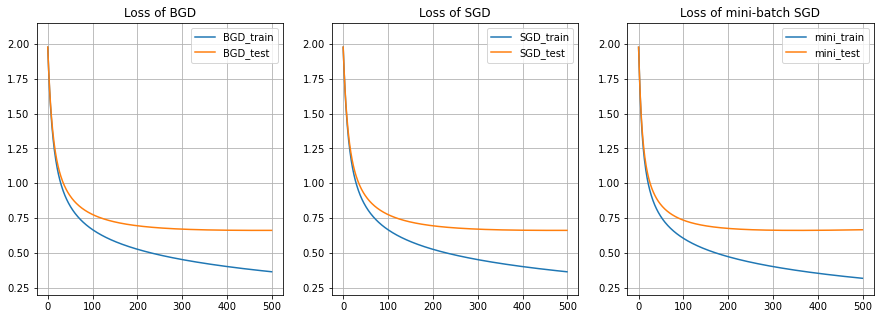

In [11]:
#cross entropy loss of three method
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.plot(BGD_train_loss, label= "BGD_train")
plt.plot(BGD_test_loss, label= "BGD_test")
plt.ylim(0.2,2.15)
plt.grid()
plt.legend()
plt.title("Loss of BGD")

plt.subplot(1,3,2)
plt.plot(SGD_train_loss, label= "SGD_train")
plt.plot(SGD_test_loss, label= "SGD_test")
plt.ylim(0.2,2.15)
plt.grid()
plt.legend()
plt.title("Loss of SGD")

plt.subplot(1,3,3)
plt.plot(mini_train_loss, label= "mini_train")
plt.plot(mini_test_loss, label= "mini_test")
plt.ylim(0.2,2.15)
plt.grid()
plt.legend()
plt.title("Loss of mini-batch SGD")

plt.show()

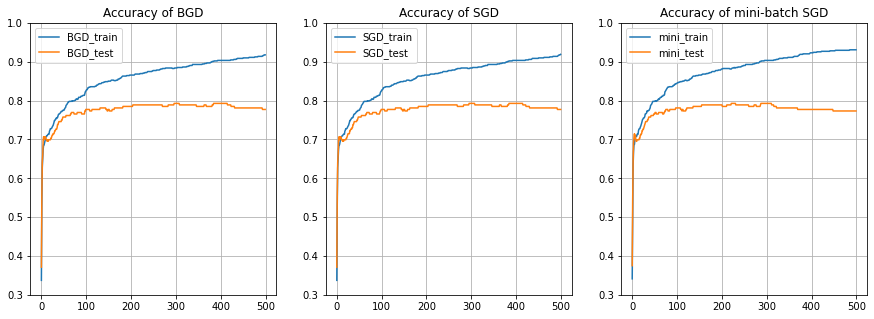

In [12]:
#accuracy of three method
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.plot(BGD_train_acc, label= "BGD_train")
plt.plot(BGD_test_acc, label= "BGD_test")
plt.ylim(0.3,1)
plt.grid()
plt.legend(loc=2)
plt.title("Accuracy of BGD")

plt.subplot(1,3,2)
plt.plot(SGD_train_acc, label= "SGD_train")
plt.plot(SGD_test_acc, label= "SGD_test")
plt.ylim(0.3,1)
plt.legend(loc=2)
plt.grid()
plt.title("Accuracy of SGD")


plt.subplot(1,3,3)
plt.plot(mini_train_acc, label= "mini_train")
plt.plot(mini_test_acc, label= "mini_test")
plt.ylim(0.3,1)
plt.grid()
plt.legend(loc=2)
plt.title("Accuracy of mini-batch SGD")

plt.show()

# Q1.2.b

In [13]:
pd.DataFrame({"Loss":[BGD_train_loss[-1], BGD_test_loss[-1], SGD_train_loss[-1],
                      SGD_test_loss[-1], mini_train_loss[-1], mini_test_loss[-1]],
              "Accuracy":[BGD_train_acc[-1], BGD_test_acc[-1], SGD_train_acc[-1],
                          SGD_test_acc[-1], mini_train_acc[-1], mini_test_acc[-1]]},
             index = [["BGD","BGD","SGD","SGD","mini-batch SGD","mini-batch SGD"],
                      ["Training","Testing","Training","Testing","Training","Testing"]
                     ]
            ).round(4)

Loss  Accuracy
BGD            Training  0.3654    0.9180
               Testing   0.6622    0.7773
SGD            Training  0.3652    0.9193
               Testing   0.6622    0.7773
mini-batch SGD Training  0.3185    0.9310
               Testing   0.6667    0.7734

# Q1.2.c

on PDF

# Q1.3

on PDF

# Q2

In [14]:
# define class for Gaussian Process for Regression
class GPR:
    def __init__(self, theta, X_train, Y_train, X_test, Y_test, poly = False, beta_inv = 1):
        self.theta = theta
        self.n = len(X_train)
        self.beta_inv = beta_inv
        self.Y = Y_train
        self.Y_t = Y_test
        self.poly = poly
        if self.poly:
            self.X = self.m2(X_train)
            self.X_t = self.m2(X_test)
        else:
            self.X = X_train
            self.X_t = X_test
    def m2(self, x):
        A = np.append(np.ones((len(x),1)),x,axis=1)
        A = np.append(A, (x[:,0]*x[:,0]).reshape(-1,1),axis = 1)
        return A
    
    def cov_inv(self):
        cov = np.zeros((self.n, self.n))
        for i in range(self.n):
            for j in range(self.n):
                cov[i,j] = self.kernel_f(self.X[i], self.X[j])
                if i == j:
                    cov[i,j] += self.beta_inv
        cov_inv = np.linalg.inv(cov)
        return cov_inv
    
    def predict(self, X):
        cov_inv = self.cov_inv()
        y = np.array([])
        std = np.array([])
        for i in X:
            mean, var = self.cal_Gaussian(i, cov_inv)
            y = np.append(y, mean)
            std = np.append(std, np.sqrt(var))
        return y, std
    
    def kernel_f(self, xi, xj):
        return self.theta[0] * np.exp(-self.theta[1]*0.5 * ((xi - xj)@(xi - xj))) + self.theta[2] + self.theta[3] * (xi @ xj)
    
    def cal_Gaussian(self, xn, cov_inv):
        k = np.zeros((self.n, 1))
        for i in range(self.n):
            k[i,0] = self.kernel_f(self.X[i], xn)
        c = self.kernel_f(xn, xn) + self.beta_inv
        mean = k.T @ cov_inv @ self.Y
        var = c - k.T @ cov_inv @ k
        return mean, var
    
    def rmse(self, X, Y):
        Y_hat = self.predict(X)[0]
        return np.sqrt(np.mean((Y-Y_hat)**2))
    
    def plot(self, X, Y):
        x = np.linspace(np.min(X), np.max(X), self.n)
        if self.poly:
            y = self.predict(self.m2(x.reshape(-1,1)))[0]
            std = self.predict(self.m2(x.reshape(-1,1)))[1]
        else:
            y = self.predict(x.reshape(-1,1))[0]
            std = self.predict(x.reshape(-1,1))[1]
        plt.plot(x, y, c='r') 
        plt.fill_between(x, y - std, y + std, color='pink')
        plt.scatter(X, Y, s=20)
        plt.title("θ = " + str(self.theta), fontsize = 15)
        plt.xlabel("x", fontsize = 14)
        plt.ylabel("t", fontsize = 14)
        plt.grid()
        plt.show()
        print("RMSE of training data : ", self.rmse(self.X, self.Y))
        print("RMSE of testing  data : ",self.rmse(self.X_t, self.Y_t))
        print("-" * 50)
        
#define class for tuning 
class GPR_tune:
    def __init__(self, grid_search):
        self.theta0 = grid_search["theta0"]
        self.theta1 = grid_search["theta1"]
        self.theta2 = grid_search["theta2"]
        self.theta3 = grid_search["theta3"]
        
    def train(self, X_train, Y_train, X_test, Y_test, poly = False, beta_inv = 1):
        para_lst = []
        rmse_lst = []
        for t0 in self.theta0:
            for t1 in self.theta1:
                for t2 in self.theta2:
                    for t3 in self.theta3:
                        para = []
                        para.append(t0)
                        para.append(t1)
                        para.append(t2)
                        para.append(t3)
                        model = GPR([t0, t1, t2, t3], X_train, Y_train, X_test, Y_test)
                        para_lst.append(para)
                        rmse_lst.append(model.rmse(X_test, Y_test))
        best_ind = np.argmin(rmse_lst)
        return para_lst[best_ind], rmse_lst[best_ind]

In [15]:
X = pd.read_csv("x.csv",header = None)
X = np.array(X)
X_train = X[:150]
X_test = X[150:]

Y = pd.read_csv("t.csv",header = None)
Y = np.array(Y)
Y_train = Y[:150].flatten()
Y_test = Y[150:].flatten()

# Q2.1/ Q2.3/ Q2.4

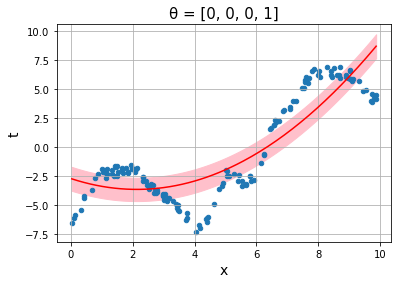

RMSE of training data :  2.0663562981769155
RMSE of testing  data :  2.097134900513137
--------------------------------------------------


In [16]:
model = GPR([0,0,0,1], X_train, Y_train, X_test, Y_test, poly = True)
model.plot(X_train, Y_train)

# Q2.2/ Q2.3/ Q2.4

In [17]:
theta_config = [[0, 0,  0, 1],
                [1, 8,  0, 0],
                [1, 1,  0, 16],
                [1, 1, 32, 0]]

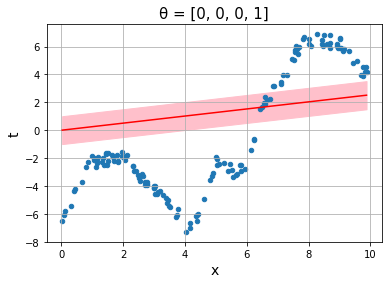

RMSE of training data :  4.082716846775828
RMSE of testing  data :  3.932616991913908
--------------------------------------------------


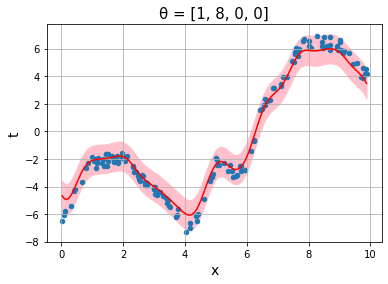

RMSE of training data :  0.46961784610996815
RMSE of testing  data :  0.493027455823314
--------------------------------------------------


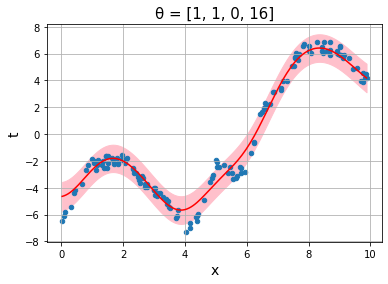

RMSE of training data :  0.6044969015601664
RMSE of testing  data :  0.5809786110384609
--------------------------------------------------


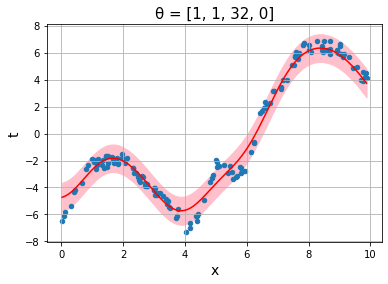

RMSE of training data :  0.6024902451849607
RMSE of testing  data :  0.5866270617532747
--------------------------------------------------


In [18]:
for i in theta_config:
    model = GPR(i, X_train, Y_train, X_test, Y_test)
    model.plot(X_train, Y_train)

# Q2.5

In [19]:
parameter = {"theta0":[0, 2, 4, 8, 16, 32], "theta1":[0, 2, 4, 8, 16, 32],
             "theta2":[0, 2, 4, 8, 16, 32], "theta3":[0, 2, 4, 8, 16, 32]}

model = GPR_tune(parameter)
re = model.train(X_train, Y_train, X_test, Y_test)

In [20]:
print("Best hyperparameter theta",re[0])
print("RMSE of the condition", re[1])

Best hyperparameter theta [32, 2, 0, 0]
RMSE of the condition 0.3030063676479589


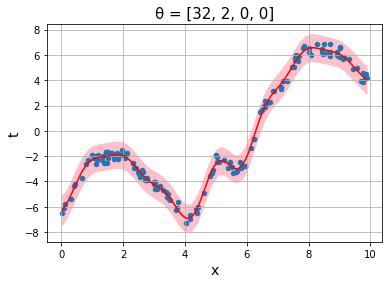

RMSE of training data :  0.27475679059456176
RMSE of testing  data :  0.3030063676479589
--------------------------------------------------


In [21]:
model = GPR(re[0], X_train, Y_train, X_test, Y_test)
model.plot(X_train, Y_train)

# Q2.6

On PDF